In [1]:
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns
import pandas as pd
import glob
import numpy as np
from scipy.special import softmax
import re

def process_logits(logit_str, top_p=None):
    logit_lines = logit_str.split('\n')
    instruction, prompt, _ = logit_lines[:3]
    sequence_logits = []
    for idx, line in enumerate(logit_lines[3:]):
        if line == '':
            continue
        logit_type, logits = line.split()[0].replace(':', ''), line.split()[1:]
        logits = list(map(lambda x: round(float(x), 4), logits))

        # if `top_p` is specified, we just get the top p tokens, otherwise we get logits for all tokens.
        if top_p is not None:
            logits = get_top_p_tokens(logits, p=top_p)

        #
        sequence_logits.append({
            'logit_type': logit_type,
            'logits': logits,
            'idx': int(idx / 2)
        })

    return {
        'instruction': instruction,
        'prompt': prompt,
        'all_logits': sequence_logits,
    }

def get_top_p_tokens(logits, p=.9):
    ps = softmax(logits)
    arg_sorted_desc = ps.argsort()[::-1]
    cumprobs = np.cumsum(ps[arg_sorted_desc])
    top_p = cumprobs[cumprobs < p].shape[0]
    top_p_tokens = arg_sorted_desc[:top_p]
    return top_p_tokens

# Read in Files

In [2]:
all_logit_files = glob.glob('../logit-files__*')
models = list(map(lambda x: re.search('logit-files__(.*)__(\d+).txt', x).groups(), all_logit_files))

In [6]:
from tqdm.auto import tqdm

In [14]:
all_logits = []
for m, f in tqdm(zip(models, all_logit_files), total=len(models)):
    all_logits.append({
        'model': m[0],
        'prompt_num': int(m[1]),
        # 'logits_parsed': process_logits(open(f).read()),
        'top_p_tokens': process_logits(open(f).read(), top_p=.9),
    })

  0%|          | 0/15 [00:00<?, ?it/s]

In [15]:
all_logits_df = pd.DataFrame(all_logits)
# del all_logits

# Tests

In [37]:
all_logits_df.iloc[0]['top_p_tokens']['all_logits']

[{'logit_type': 'prompted_logits',
  'logits': array([ 4923, 31541,  1500,   733,   754,  1916, 46797,   309]),
  'idx': 0},
 {'logit_type': 'unprompted_logits',
  'logits': array([  187,   346,   686, ...,  6884, 32296, 27656]),
  'idx': 0},
 {'logit_type': 'prompted_logits',
  'logits': array([  352,   344, 29466,   703,   627, 37866]),
  'idx': 1},
 {'logit_type': 'unprompted_logits',
  'logits': array([  273,   309,   253, ..., 13949,  7681,  1158]),
  'idx': 1},
 {'logit_type': 'prompted_logits',
  'logits': array([ 3078,   369,  3047,   574,  5605, 13052, 13405,  6337,  3260,
          3735, 10490,  1869, 16780,   812,  1694, 18739,  7428,  4571]),
  'idx': 2},
 {'logit_type': 'unprompted_logits',
  'logits': array([  434,   310,   457,   369,   556,  2506,   651,   476,   588,
          2789,  3589,  3133,  3936,  3548,  1057,   574,  2097,  4453,
           816,  1904,  4483,  2987,  4245,  2335,   812,  9193,  1663,
           778,  2296,  7835,  3249,   187,  7729,  1537,   9

In [39]:
print(pd.DataFrame(all_logits_df.iloc[0]['top_p_tokens']['all_logits']).head())

          logit_type                                             logits  idx
0    prompted_logits    [4923, 31541, 1500, 733, 754, 1916, 46797, 309]    0
1  unprompted_logits  [187, 346, 686, 337, 361, 470, 253, 380, 209, ...    0
2    prompted_logits                 [352, 344, 29466, 703, 627, 37866]    1
3  unprompted_logits  [273, 309, 253, 352, 368, 13, 359, 597, 627, 3...    1
4    prompted_logits  [3078, 369, 3047, 574, 5605, 13052, 13405, 633...    2


In [40]:
def get_logit_statistics(one_doc):
    one_prompt_logits = pd.DataFrame(one_doc['top_p_tokens']['all_logits']).rename(columns={'logits': 'top_p_tokens'})
    one_prompt_logits = (one_prompt_logits
        .groupby('idx')
        .apply(lambda df:
            pd.Series({
                'top_p_prompted_tokens': df.loc[df['logit_type'] == 'prompted_logits', 'top_p_tokens'].iloc[0],
                'top_p_unprompted_tokens': df.loc[df['logit_type'] == 'unprompted_logits', 'top_p_tokens'].iloc[0]
            })
        )
        .assign(num_top_p_toks_prompted=lambda df: df['top_p_prompted_tokens'].str.len())
        .assign(num_top_p_toks_unprompted=lambda df: df['top_p_unprompted_tokens'].str.len())
        .assign(num_overlap=lambda df: df.apply(lambda row: len(set(row['top_p_prompted_tokens']) & set(row['top_p_unprompted_tokens'])),axis=1))
     )
    one_prompt_logits['model'] = one_doc['model']
    one_prompt_logits['prompt_num'] = one_doc['prompt_num']
    return one_prompt_logits

In [41]:
from tqdm.auto import tqdm
tqdm.pandas()
logit_stats = all_logits_df.progress_apply(get_logit_statistics, axis=1)

  0%|          | 0/15 [00:00<?, ?it/s]

In [47]:
logit_stats_df = pd.concat(logit_stats.tolist())

In [53]:
logit_stats_df

,top_p_prompted_tokens,top_p_unprompted_tokens,num_top_p_toks_prompted,num_top_p_toks_unprompted,num_overlap,model,prompt_num
idx,,,,,,,
0,"[4923, 31541, 1500, 733, 754, 1916, 46797, 309]","[187, 346, 686, 337, 361, 470, 253, 380, 209, ...",8,8325,6,EleutherAI-pythia-1.4b,0
1,"[352, 344, 29466, 703, 627, 37866]","[273, 309, 253, 352, 368, 13, 359, 597, 627, 3...",6,1047,4,EleutherAI-pythia-1.4b,0
2,"[3078, 369, 3047, 574, 5605, 13052, 13405, 633...","[434, 310, 457, 369, 556, 2506, 651, 476, 588,...",18,94,5,EleutherAI-pythia-1.4b,0
3,"[8463, 1633, 281, 11624, 37866, 12173, 2739, 6...","[281, 253, 479, 247, 368, 441, 779, 731, 352, ...",71,25,8,EleutherAI-pythia-1.4b,0
4,"[2, 432, 15, 1051, 313, 187, 323, 2490, 535, 5...","[15, 13, 285, 323, 281, 449, 275, 432, 187, 2,...",24,58,15,EleutherAI-pythia-1.4b,0
...,...,...,...,...,...,...,...
114,"[28752, 40377, 30490, 35842, 19677, 32083, 743...","[220, 198, 11, 357, 197, 262, 290, 12, 366, 16...",66,18,0,nomic-ai-gpt4all-j,3
115,[18544],[],1,0,0,nomic-ai-gpt4all-j,3
116,"[3503, 32083, 35842, 40377, 743, 24584, 19677,...",[],101,0,0,nomic-ai-gpt4all-j,3


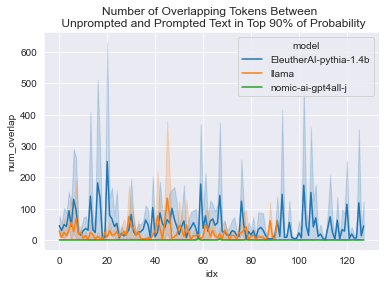

In [58]:
import matplotlib.pyplot as plt

sns.lineplot(
    data=logit_stats_df.reset_index(),
    x='idx',
    y='num_overlap',
    hue='model'
)
plt.title('Number of Overlapping Tokens Between \n Unprompted and Prompted Text in Top 90% of Probability')
plt.savefig('overlap.png', bbox_inches='tight')

# Other Tests

In [ ]:
one_prompt_logits = pd.DataFrame(
    all_logits_df['logit_parsed']
        .iloc[0] ## get the first document
        ['all_logits']
)
one_prompt_logits.head(4)
one_prompt_logits['entropy'] = one_prompt_logits['logits'].apply(lambda x: entropy(x, base=2))
sns.lineplot(data=one_prompt_logits, x='idx', y='entropy', hue='logit_type')

In [ ]:
# number of tokens in with top_p > 90%
sns.lineplot(
    data=one_prompt_logits.assign(top_p_tokens_len=lambda df: df['top_p_tokens'].str.len()),
    x='idx',
    y='top_p_tokens_len',
    hue='logit_type'
)